In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [7]:
import shap

# 1. Load data

In [8]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [9]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5874,2968-SSGAA,Female,0,No,No,10,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,100.60,1060.2,Yes
983,8603-IJWDN,Male,0,No,No,1,Yes,Yes,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,86.60,86.6,Yes
3811,3620-MWJNE,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,Yes,No,No,Month-to-month,Yes,Mailed check,54.45,87.3,No
4525,6578-KRMAW,Male,0,No,No,32,Yes,No,Fiber optic,Yes,...,Yes,No,No,Yes,Month-to-month,Yes,Credit card (automatic),93.40,2979.3,No
1756,0134-XWXCE,Female,1,No,No,44,Yes,No,DSL,No,...,Yes,Yes,Yes,Yes,One year,No,Bank transfer (automatic),74.85,3268.05,No


In [10]:
df.shape

(7043, 21)

# 2. Check data quality

data type

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
df[['TotalCharges']].head()

,TotalCharges
0,29.85
1,1889.5
2,108.15
3,1840.75
4,151.65


In [13]:
# There is a wrong datatype in TotalCharges.

In [14]:
def empty_or_whitespace_strings(df):
    string_columns = df.select_dtypes(include=['object']).columns
    empty_whitespace_check = df[string_columns].applymap(lambda x: isinstance(x, str) and x.isspace())

    count_empty_whitespace = empty_whitespace_check.sum()
    rows_with_whitespace_indices = empty_whitespace_check.any(axis=1)
    list_row_with_whilespace_indices = df.index[rows_with_whitespace_indices].tolist()

    return count_empty_whitespace, list_row_with_whilespace_indices

In [15]:
show_whilespace, indices_whilesapce = empty_or_whitespace_strings(df)

In [16]:
show_whilespace

customerID           0
gender               0
Partner              0
Dependents           0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
TotalCharges        11
Churn                0
dtype: int64

In [17]:
indices_whilesapce

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

In [18]:
df.loc[indices_whilesapce, 'TotalCharges'] = np.nan

In [19]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

unique value

In [20]:
df.shape

(7043, 21)

In [21]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  customerID
Unique value:  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Count unique value:  7043
----------
Columns name:  gender
Unique value:  ['Female' 'Male']
Count unique value:  2
----------
Columns name:  SeniorCitizen
Unique value:  [0 1]
Count unique value:  2
----------
Columns name:  Partner
Unique value:  ['Yes' 'No']
Count unique value:  2
----------
Columns name:  Dependents
Unique value:  ['No' 'Yes']
Count unique value:  2
----------
Columns name:  tenure
Unique value:  [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Count unique value:  73
----------
Columns name:  PhoneService
Unique value:  ['No' 'Yes']
Count unique value:  2
----------
Columns name:  MultipleLines
Unique value:  ['No phone service' 'No' 'Yes']
Count unique value:  3
------

missing value

In [22]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

# 4. Exploratory data analysis (EDA)

list of columns by types

In [23]:
id_col = ['customerID']

In [24]:
target_col = ['Churn']

In [25]:
cat_col = ['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 
           'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
           'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod']

In [26]:
num_col = ['tenure', 'MonthlyCharges', 'TotalCharges']

target

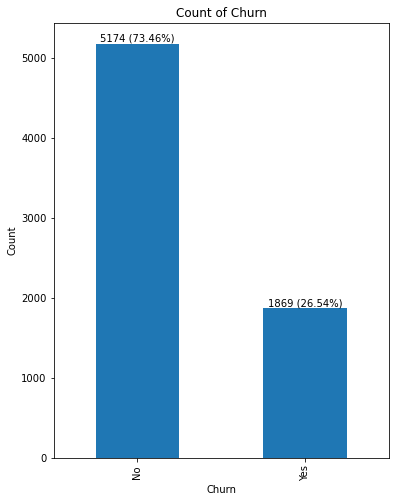

In [27]:
for column in target_col:
    category_counts = df[column].value_counts()
    total_count = len(df[column])
    plt.figure(figsize=(6, 8))
    ax = category_counts.plot(kind='bar')
    for i, count in enumerate(category_counts):
        percentage = (count / total_count) * 100
        ax.annotate(f'{count} ({percentage:.2f}%)', xy=(i, count), ha='center', va='bottom')
    
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Count of {column}')
    plt.show()

In [28]:
# Within the "Churn" columns, an imbalance problem is evident.
# To address this issue, we can consider applying undersampling or oversampling techniques.

categorical features

In [29]:
df[cat_col].describe(include='object')

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365


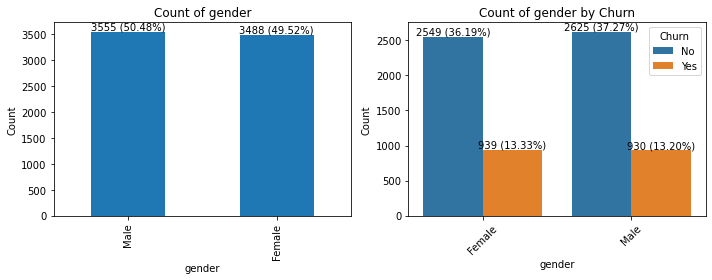

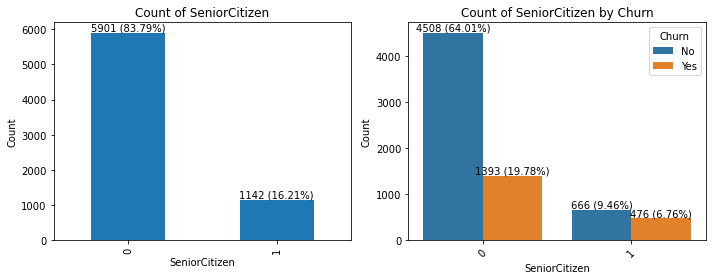

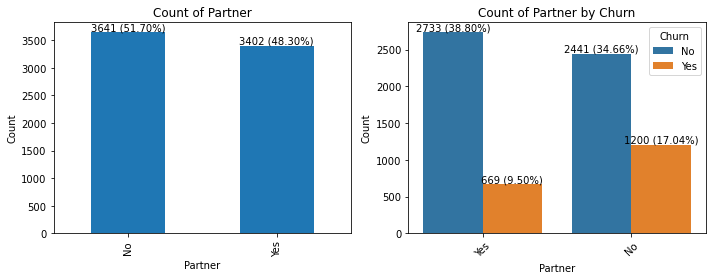

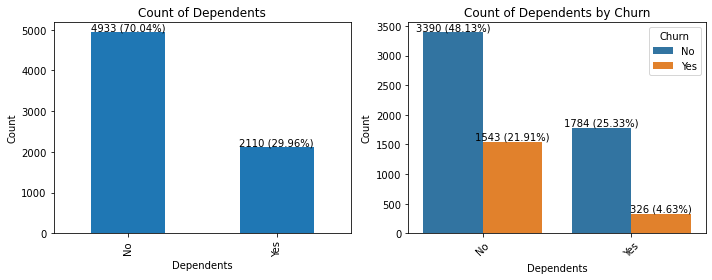

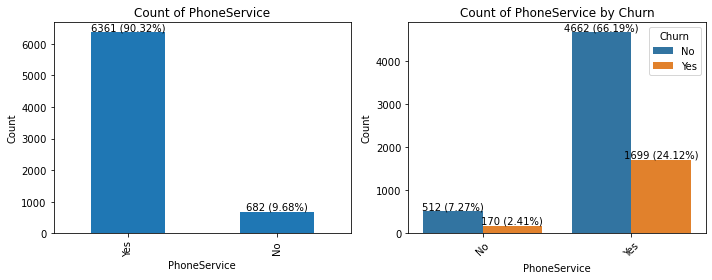

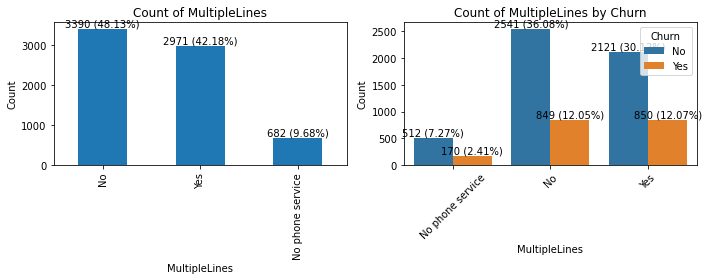

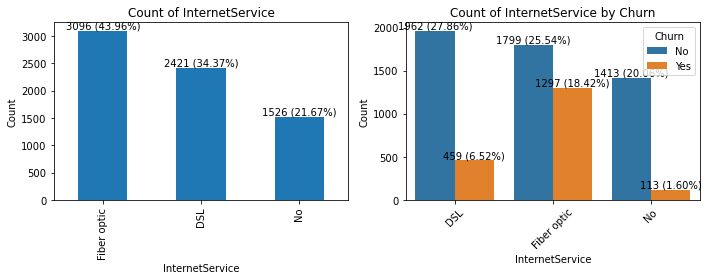

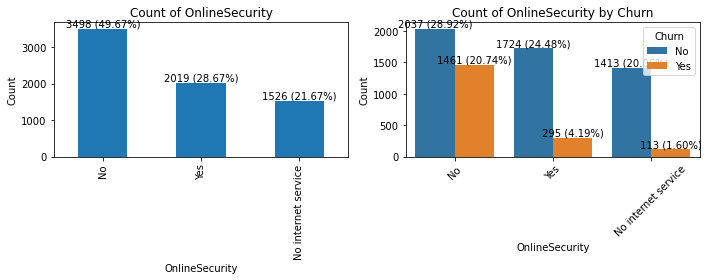

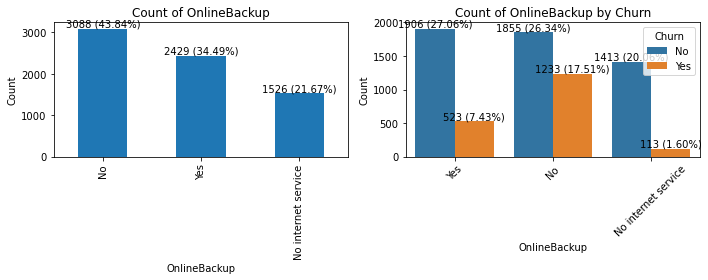

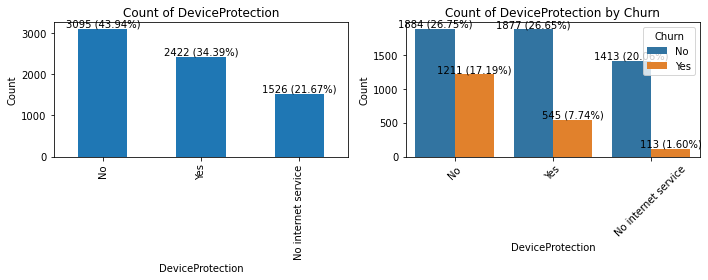

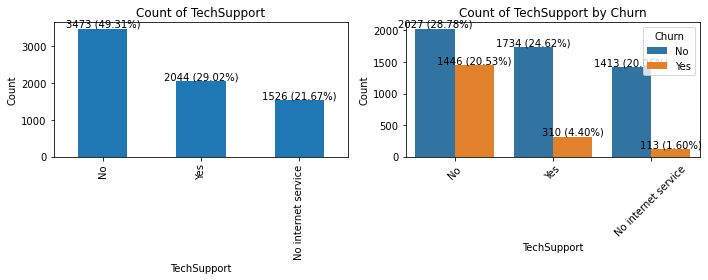

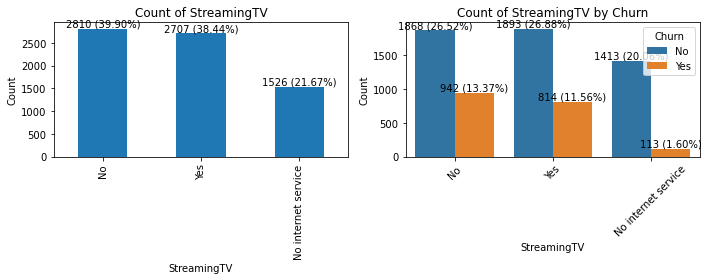

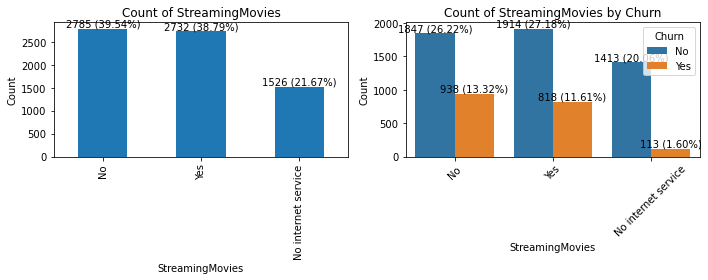

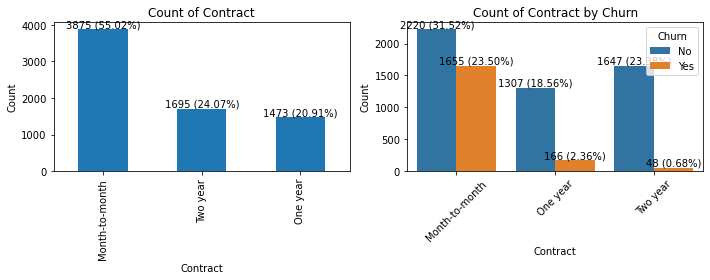

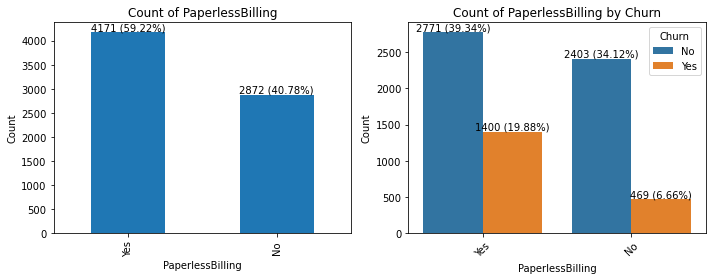

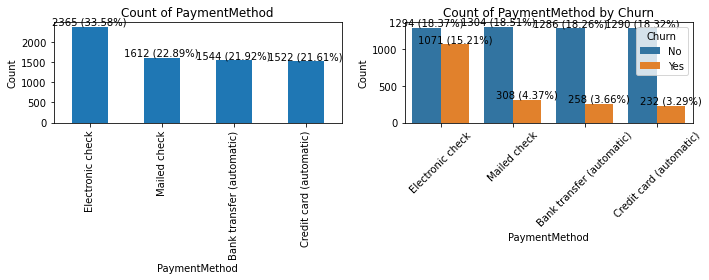

In [30]:
for column in cat_col:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Left subplot - Bar chart
    category_counts = df[column].value_counts()
    total_count = len(df[column])
    ax = category_counts.plot(kind='bar', ax=axes[0])
    for i, count in enumerate(category_counts):
        percentage = (count / total_count) * 100
        ax.annotate(f'{count} ({percentage:.2f}%)', xy=(i, count), ha='center', va='bottom')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Count of {column}')
    
    # Right subplot - Count plot with hue='Churn' and percentages
    sns.countplot(data=df, x=column, hue='Churn', ax=axes[1])
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'Count of {column} by Churn')
    axes[1].legend(title='Churn', loc='upper right', labels=['No', 'Yes'])
    axes[1].tick_params(axis='x', rotation=45)
    
    # Annotate bars with percentages in the right subplot
    for bar in axes[1].patches:
        total_height = bar.get_height()
        percentage = (total_height / total_count) * 100
        text_x = bar.get_x() + bar.get_width() / 2
        text_y = total_height
        axes[1].annotate(f'{int(total_height)} ({percentage:.2f}%)',
                         (text_x, text_y),
                         ha='center',
                         va='bottom')

    plt.tight_layout()
    plt.show()

In [31]:
# The phrase "No internet service" appears in 6 variables, all with the same frequency of 1526.
# Can represent the "Contract" variable as an ordinal variable with values 0, 1, and 2.

numerical features

In [32]:
df[num_col].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


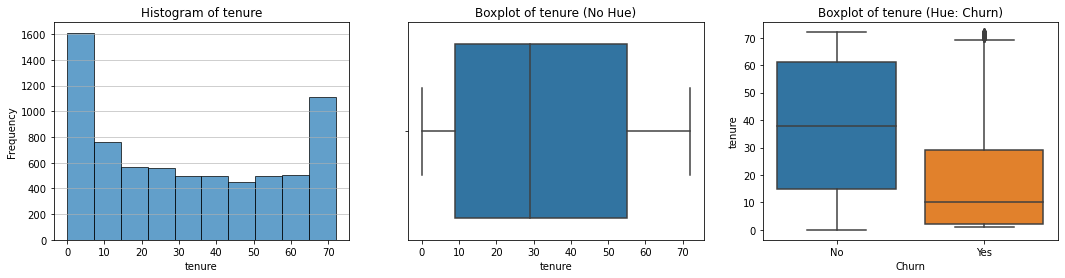

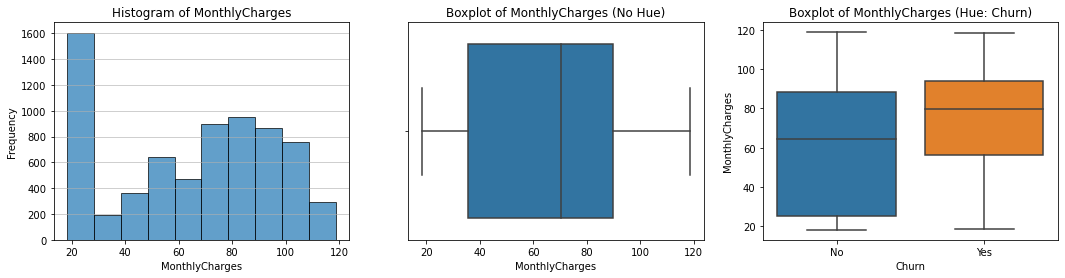

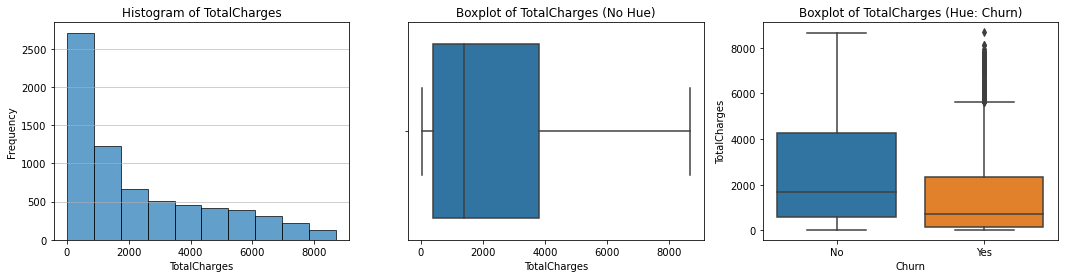

In [33]:
for column_name in num_col:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    
    # Create a histogram
    ax1.hist(df[column_name], bins=10, edgecolor='black', alpha=0.7)
    ax1.set_title(f'Histogram of {column_name}')
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Frequency')
    ax1.grid(axis='y', alpha=0.75)
    
    # Create a boxplot without hue
    sns.boxplot(x=df[column_name], ax=ax2)
    ax2.set_title(f'Boxplot of {column_name} (No Hue)')
    ax2.set_xlabel(column_name)
    
    # Create a boxplot with hue='Churn'
    sns.boxplot(x='Churn', y=column_name, data=df, ax=ax3)
    ax3.set_title(f'Boxplot of {column_name} (Hue: Churn)')
    ax3.set_xlabel('Churn')
    ax3.set_ylabel(column_name)
    
    plt.show()

In [34]:
# The distribution of 'TotalCharges' is right-skewed. Use the median to replace missing values instead of the mean.

# 5. Feature engineering

target

In [35]:
# target

In [36]:
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

features

In [37]:
# PaymentMethod (one hot)

In [38]:
for payment_method in df['PaymentMethod'].unique():
    df['PaymentMethod_' + payment_method] = df['PaymentMethod'].apply(lambda x: 1 if x == payment_method else 0)
df = df.drop('PaymentMethod', axis=1)

In [39]:
# Gender

In [40]:
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [41]:
# Partner

In [42]:
df['Partner'] = df['Partner'].apply(lambda x: 1 if x == 'Yes' else 0)

In [43]:
# Dependents

In [44]:
df['Dependents'] = df['Dependents'].apply(lambda x: 1 if x == 'Yes' else 0)

In [45]:
# PhoneService

In [46]:
df['PhoneService'] = df['PhoneService'].apply(lambda x: 1 if x == 'Yes' else 0)

In [47]:
# MultipleLines

In [48]:
df['MultipleLines'] = df['MultipleLines'].apply(lambda x: 1 if x == 'Yes' else 0)

In [49]:
# InternetService

In [50]:
df['InternetService'] = df['InternetService'].apply(lambda x: 2 if x == 'Fiber optic' else 1 if x == 'DSL' else 0)

In [51]:
# OnlineSecurity

In [52]:
df['OnlineSecurity'] = df['OnlineSecurity'].apply(lambda x: 1 if x == 'Yes' else 0)

In [53]:
# OnlineBackup

In [54]:
df['OnlineBackup'] = df['OnlineBackup'].apply(lambda x: 1 if x == 'Yes' else 0)

In [55]:
# DeviceProtection

In [56]:
df['DeviceProtection'] = df['DeviceProtection'].apply(lambda x: 1 if x == 'Yes' else 0)

In [57]:
# TechSupport

In [58]:
df['TechSupport'] = df['TechSupport'].apply(lambda x: 1 if x == 'Yes' else 0)

In [59]:
# StreamingTV

In [60]:
df['StreamingTV'] = df['StreamingTV'].apply(lambda x: 1 if x == 'Yes' else 0)

In [61]:
# StreamingMovies

In [62]:
df['StreamingMovies'] = df['StreamingMovies'].apply(lambda x: 1 if x == 'Yes' else 0)

In [63]:
# Contract

In [64]:
df['Contract'] = df['Contract'].apply(lambda x: 0 if x == 'Month-to-month' else 1 if x == 'One year' else 2)

In [65]:
# PaperlessBilling

In [66]:
df['PaperlessBilling'] = df['PaperlessBilling'].apply(lambda x: 1 if x == 'Yes' else 0)

fill na

In [67]:
df.isna().sum()

customerID                                  0
gender                                      0
SeniorCitizen                               0
Partner                                     0
Dependents                                  0
tenure                                      0
PhoneService                                0
MultipleLines                               0
InternetService                             0
OnlineSecurity                              0
OnlineBackup                                0
DeviceProtection                            0
TechSupport                                 0
StreamingTV                                 0
StreamingMovies                             0
Contract                                    0
PaperlessBilling                            0
MonthlyCharges                              0
TotalCharges                               11
Churn                                       0
PaymentMethod_Electronic check              0
PaymentMethod_Mailed check        

In [68]:
# TotalCharges

In [69]:
median_tol_charges = df['TotalCharges'].median()

In [70]:
median_tol_charges

1397.475

In [71]:
df['TotalCharges'].fillna(median_tol_charges, inplace=True)

In [72]:
df.isna().sum()

customerID                                 0
gender                                     0
SeniorCitizen                              0
Partner                                    0
Dependents                                 0
tenure                                     0
PhoneService                               0
MultipleLines                              0
InternetService                            0
OnlineSecurity                             0
OnlineBackup                               0
DeviceProtection                           0
TechSupport                                0
StreamingTV                                0
StreamingMovies                            0
Contract                                   0
PaperlessBilling                           0
MonthlyCharges                             0
TotalCharges                               0
Churn                                      0
PaymentMethod_Electronic check             0
PaymentMethod_Mailed check                 0
PaymentMet

drop unnecessary columns

In [73]:
# drop customerID

In [74]:
df.drop(columns = 'customerID', inplace = True)

correlation

In [75]:
# check correlation

In [76]:
corr = df.corr()

<AxesSubplot:>

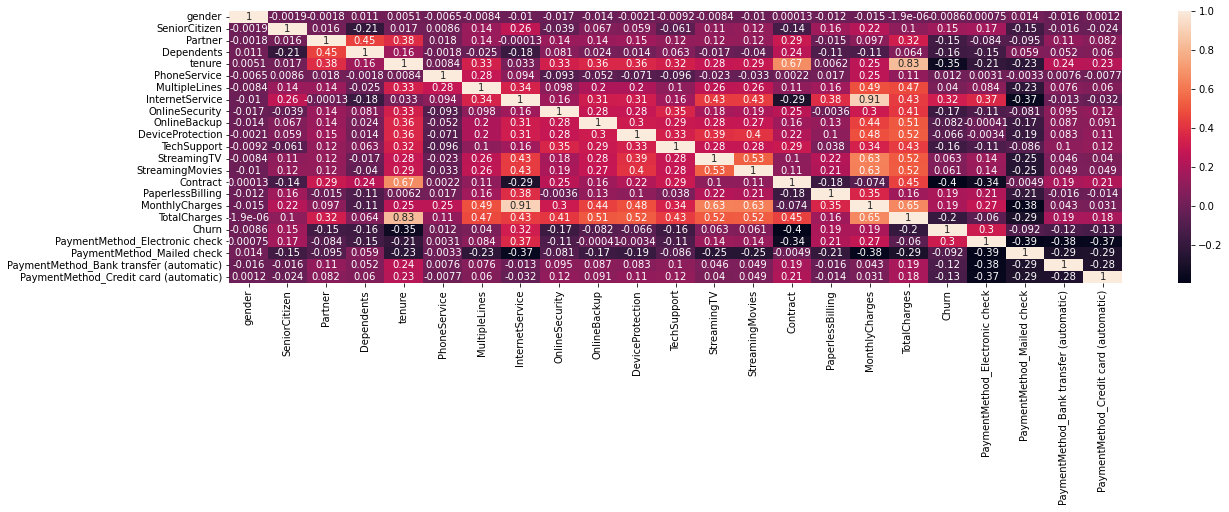

In [77]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(corr, annot=True, ax=ax)

In [78]:
corr_churn_table = corr['Churn'].sort_values(ascending=False)

In [79]:
corr_churn_table

Churn                                      1.000000
InternetService                            0.316846
PaymentMethod_Electronic check             0.301919
MonthlyCharges                             0.193356
PaperlessBilling                           0.191825
SeniorCitizen                              0.150889
StreamingTV                                0.063228
StreamingMovies                            0.061382
MultipleLines                              0.040102
PhoneService                               0.011942
gender                                    -0.008612
DeviceProtection                          -0.066160
OnlineBackup                              -0.082255
PaymentMethod_Mailed check                -0.091683
PaymentMethod_Bank transfer (automatic)   -0.117937
PaymentMethod_Credit card (automatic)     -0.134302
Partner                                   -0.150448
Dependents                                -0.164221
TechSupport                               -0.164674
OnlineSecuri

In [80]:
corr_churn_abs_table = corr['Churn'].abs().sort_values(ascending=False)

In [81]:
corr_churn_abs_table

Churn                                      1.000000
Contract                                   0.396713
tenure                                     0.352229
InternetService                            0.316846
PaymentMethod_Electronic check             0.301919
TotalCharges                               0.199037
MonthlyCharges                             0.193356
PaperlessBilling                           0.191825
OnlineSecurity                             0.171226
TechSupport                                0.164674
Dependents                                 0.164221
SeniorCitizen                              0.150889
Partner                                    0.150448
PaymentMethod_Credit card (automatic)      0.134302
PaymentMethod_Bank transfer (automatic)    0.117937
PaymentMethod_Mailed check                 0.091683
OnlineBackup                               0.082255
DeviceProtection                           0.066160
StreamingTV                                0.063228
StreamingMov

# 6. Model

In [82]:
# Only Class 0
# Only Class 1

# Normalized > SMOTE > RF (Random Search)
# Normalized > SMOTE > LightGBM (Random Search)
# Normalized > SMOTE > XGBoost (Random Search)

# Normalized > ADASYN > RF (Random Search)
# Normalized > ADASYN > LightGBM (Random Search)
# Normalized > ADASYN > XGBoost (Random Search)

# Normalized > RUS > RF (Random Search)
# Normalized > RUS > LightGBM (Random Search)
# Normalized > RUS > XGBoost (Random Search)

Step 1: Train/Test/Validation Split

In [83]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [84]:
X_train = train_df.drop(columns=['Churn'])
y_train = train_df['Churn']
X_val = val_df.drop(columns=['Churn'])
y_val = val_df['Churn']
X_test = test_df.drop(columns=['Churn'])
y_test = test_df['Churn']

In [85]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)
 
print(X_test.shape)
print(y_test.shape)

(4507, 22)
(4507,)
(1127, 22)
(1127,)
(1409, 22)
(1409,)


Step 2: Normalize Min-Max Scaling

In [86]:
scaler = MinMaxScaler()

In [87]:
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Step 3.1: predicts only 1

In [88]:
dummy_all_churn = DummyClassifier(strategy='constant', constant=1)
dummy_all_churn.fit(X_train_scaled, y_train)

DummyClassifier(constant=1, strategy='constant')

Step 3.2: predicts only 0

In [89]:
dummy_all_not_churn = DummyClassifier(strategy='constant', constant=0)
dummy_all_not_churn.fit(X_train_scaled, y_train)

DummyClassifier(constant=0, strategy='constant')

Step 3.3: Smote + RF

In [90]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [91]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)
rf_smote_random_search = RandomizedSearchCV(rf, param_distributions=rf_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
rf_smote_random_search.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='roc_auc')

In [92]:
rf_smote_random_search.best_score_

0.930213571441962

In [93]:
rf_smote = rf_smote_random_search.best_estimator_

Step 3.4: Smote + LGBM

In [94]:
lgbm_params = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
lgbm = LGBMClassifier(random_state=42)
lgbm_smote_random_search = RandomizedSearchCV(lgbm, param_distributions=lgbm_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
lgbm_smote_random_search.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 10, 20, 30],
                                        'min_child_samples': [20, 50, 100],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='roc_auc')

In [95]:
lgbm_smote_random_search.best_score_

0.9291587694747366

In [96]:
lgbm_smote = lgbm_smote_random_search.best_estimator_

Step 3.5: Smote + XGB

In [97]:
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}
xgb = XGBClassifier(random_state=42)
xgb_smote_random_search = RandomizedSearchCV(xgb, param_distributions=xgb_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
xgb_smote_random_search.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=100, n_jobs=None,
                     

In [98]:
xgb_smote_random_search.best_score_

0.9261674705878774

In [99]:
xgb_smote = xgb_smote_random_search.best_estimator_

Step 3.6: ADASYN + RF

In [100]:
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)

In [101]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)
rf_adasyn_random_search = RandomizedSearchCV(rf, param_distributions=rf_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
rf_adasyn_random_search.fit(X_train_adasyn, y_train_adasyn)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='roc_auc')

In [102]:
rf_adasyn_random_search.best_score_

0.927299087221037

In [103]:
rf_adasyn = rf_adasyn_random_search.best_estimator_

Step 3.7: ADASYN + LGBM

In [104]:
lgbm_params = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
lgbm = LGBMClassifier(random_state=42)
lgbm_adasyn_random_search = RandomizedSearchCV(lgbm, param_distributions=lgbm_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
lgbm_adasyn_random_search.fit(X_train_adasyn, y_train_adasyn)

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 10, 20, 30],
                                        'min_child_samples': [20, 50, 100],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='roc_auc')

In [105]:
lgbm_adasyn_random_search.best_score_

0.9287590982028431

In [106]:
lgbm_adasyn = lgbm_adasyn_random_search.best_estimator_

Step 3.8: ADASYN + XGB

In [107]:
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}
xgb = XGBClassifier(random_state=42)
xgb_adasyn_random_search = RandomizedSearchCV(xgb, param_distributions=xgb_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
xgb_adasyn_random_search.fit(X_train_adasyn, y_train_adasyn)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=100, n_jobs=None,
                     

In [108]:
xgb_adasyn_random_search.best_score_

0.9257555556984759

In [109]:
xgb_adasyn = xgb_adasyn_random_search.best_estimator_

Step 3.9: RUS + RF

In [110]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

In [111]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)
rf_rus_random_search = RandomizedSearchCV(rf, param_distributions=rf_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
rf_rus_random_search.fit(X_train_rus, y_train_rus)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='roc_auc')

In [112]:
rf_rus_random_search.best_score_

0.838155392987287

In [113]:
rf_rus = rf_rus_random_search.best_estimator_

Step 3.10: RUS + LGBM

In [114]:
lgbm_params = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
lgbm_rus = LGBMClassifier(random_state=42)
lgbm_rus_random_search = RandomizedSearchCV(lgbm_rus, param_distributions=lgbm_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
lgbm_rus_random_search.fit(X_train_rus, y_train_rus)

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 10, 20, 30],
                                        'min_child_samples': [20, 50, 100],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='roc_auc')

In [115]:
lgbm_rus_random_search.best_score_

0.8404575034843611

In [116]:
lgbm_rus = lgbm_rus_random_search.best_estimator_

Step 3.11: RUS + XGB

In [117]:
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}
xgb_rus = XGBClassifier(random_state=42)
xgb_rus_random_search = RandomizedSearchCV(xgb_rus, param_distributions=xgb_params, n_iter=20, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
xgb_rus_random_search.fit(X_train_rus, y_train_rus)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=100, n_jobs=None,
                     

In [118]:
xgb_rus_random_search.best_score_

0.8418375008195387

In [119]:
xgb_rus = xgb_rus_random_search.best_estimator_

# 7. Result (precision/recall/AUC-ROC)

In [120]:
models = {
    'Dummy Model (All Churn)': dummy_all_churn,
    'Dummy Model (All Not Churn)': dummy_all_not_churn,
    'Random Forest (SMOTE)': rf_smote,
    'LightGBM (SMOTE)': lgbm_smote,
    'XGBoost (SMOTE)': xgb_smote,

    'Random Forest (ADASYN)': rf_adasyn,
    'LightGBM (ADASYN)': lgbm_adasyn,
    'XGBoost (ADASYN)': xgb_adasyn,

    'Random Forest (RUS)': rf_rus,
    'LightGBM (RUS)': lgbm_rus,
    'XGBoost (RUS)': xgb_rus
}

In [121]:
summary_metrics = pd.DataFrame(columns=['Model', 'Observation', 'TP', 'TN', 'FP', 'FN', 'Precision', 'Recall', 'AUCROC'])

In [122]:
for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    model_summary = pd.DataFrame({
        'Model': [model_name],
        'Observation': [len(y_test)],
        'TP': [tp],
        'TN': [tn],
        'FP': [fp],
        'FN': [fn],
        'Precision': [precision],
        'Recall': [recall],
        'AUCROC': [auc_roc]
    })

    summary_metrics = pd.concat([summary_metrics, model_summary], ignore_index=True)

In [123]:
summary_metrics

,Model,Observation,TP,TN,FP,FN,Precision,Recall,AUCROC
0,Dummy Model (All Churn),1409,373,0,1036,0,0.264727,1.000000,0.500000
1,Dummy Model (All Not Churn),1409,0,1036,0,373,NaN,0.000000,0.500000
2,Random Forest (SMOTE),1409,212,901,135,161,0.610951,0.568365,0.839842
3,LightGBM (SMOTE),1409,216,888,148,157,0.593407,0.579088,0.838736
4,XGBoost (SMOTE),1409,253,885,151,120,0.626238,0.678284,0.857387
5,Random Forest (ADASYN),1409,208,894,142,165,0.594286,0.557641,0.835892
6,LightGBM (ADASYN),1409,217,895,141,156,0.606145,0.581769,0.840977
7,XGBoost (ADASYN),1409,245,880,156,128,0.610973,0.656836,0.855058
8,Random Forest (RUS),1409,302,783,253,71,0.544144,0.809651,0.861091
9,LightGBM (RUS),1409,306,764,272,67,0.529412,0.820375,0.857970


# 8. Tuning threshold using cost-sensitive

In [124]:
# Assume
# Cost of promotion = 100
# Cost of losing customer = 500 (5 times)

In [125]:
# ref from https://github.com/stephenblount/Churn_Classification/blob/main/Final_Analysis/Churn_Analysis_Final.ipynb

In [126]:
cost_promotion = 100
cost_loss = 500
savings_per_customer = 500

In [127]:
thresholds = np.linspace(0, 1, 101)  # 101 thresholds from 0 to 1

In [128]:
best_thresholds = {}
gains_val = {}
gains_test = {}

In [129]:
for model_name, model in models.items():

    model_gains_val = []
    model_gains_test = []

    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    if model_name == 'Dummy Model (All Churn)':
        y_pred_proba = y_pred_proba + 0.1
    elif model_name == 'Dummy Model (All Not Churn)':
        y_pred_proba = y_pred_proba - 0.1

    model_gains = []
    for threshold in thresholds:
        y_pred = (y_pred_proba > threshold).astype(int)
        cm = confusion_matrix(y_val, y_pred)
        costs = (cm[0, 1] * cost_promotion) + (cm[1, 0] * cost_loss)
        savings = cm[1, 1] * savings_per_customer
        gain = savings - costs
        model_gains.append(gain)

    best_threshold_idx = np.argmax(model_gains)
    best_threshold = thresholds[best_threshold_idx]
    
    best_thresholds[model_name] = (best_threshold, max(model_gains))
    gains_val[model_name] = model_gains
    
    y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    if model_name == 'Dummy Model (All Churn)':
        y_test_pred_proba = y_test_pred_proba + 0.1
    elif model_name == 'Dummy Model (All Not Churn)':
        y_test_pred_proba = y_test_pred_proba - 0.1 

    y_test_pred = (y_test_pred_proba > best_threshold).astype(int)
    cm_test = confusion_matrix(y_test, y_test_pred)  
    costs_test = (cm_test[0, 1] * cost_promotion) + (cm_test[1, 0] * cost_loss)
    savings_test = cm_test[1, 1] * savings_per_customer   
    gain_test = savings_test - costs_test

    gains_test[model_name] = gain_test

In [130]:
best_thresholds

{'Dummy Model (All Churn)': (0.0, 70300),
 'Dummy Model (All Not Churn)': (0.0, -152500),
 'Random Forest (SMOTE)': (0.05, 88000),
 'LightGBM (SMOTE)': (0.01, 92700),
 'XGBoost (SMOTE)': (0.07, 96300),
 'Random Forest (ADASYN)': (0.08, 91200),
 'LightGBM (ADASYN)': (0.02, 88100),
 'XGBoost (ADASYN)': (0.08, 97700),
 'Random Forest (RUS)': (0.22, 96400),
 'LightGBM (RUS)': (0.16, 95800),
 'XGBoost (RUS)': (0.19, 97300)}

In [131]:
gains_test

{'Dummy Model (All Churn)': 82900,
 'Dummy Model (All Not Churn)': -186500,
 'Random Forest (SMOTE)': 109700,
 'LightGBM (SMOTE)': 115700,
 'XGBoost (SMOTE)': 116000,
 'Random Forest (ADASYN)': 110400,
 'LightGBM (ADASYN)': 111500,
 'XGBoost (ADASYN)': 117700,
 'Random Forest (RUS)': 119800,
 'LightGBM (RUS)': 111700,
 'XGBoost (RUS)': 114900}

In [132]:
summary_thresholds = pd.DataFrame(columns=['Model', 'Best Threshold', 'Validation Gain', 'Test Gain'])

In [133]:
for model_name, model_gains_val in gains_val.items():
    best_threshold, _ = best_thresholds[model_name]

    model_summary_thresholds = pd.DataFrame({
        'Model': [model_name],
        'Best Threshold': [best_threshold],
        'Validation Gain': [max(model_gains_val)],
        'Test Gain': [gains_test[model_name]]
    })

    summary_thresholds = pd.concat([summary_thresholds, model_summary_thresholds], ignore_index=True)

In [134]:
summary_thresholds

,Model,Best Threshold,Validation Gain,Test Gain
0,Dummy Model (All Churn),0.00,70300,82900
1,Dummy Model (All Not Churn),0.00,-152500,-186500
2,Random Forest (SMOTE),0.05,88000,109700
3,LightGBM (SMOTE),0.01,92700,115700
4,XGBoost (SMOTE),0.07,96300,116000
5,Random Forest (ADASYN),0.08,91200,110400
6,LightGBM (ADASYN),0.02,88100,111500
7,XGBoost (ADASYN),0.08,97700,117700
8,Random Forest (RUS),0.22,96400,119800
9,LightGBM (RUS),0.16,95800,111700


# 9. Result (threshold/cost)

In [135]:
summary_df = pd.merge(summary_metrics, summary_thresholds, on="Model", how="left")

In [136]:
summary_df

,Model,Observation,TP,TN,FP,FN,Precision,Recall,AUCROC,Best Threshold,Validation Gain,Test Gain
0,Dummy Model (All Churn),1409,373,0,1036,0,0.264727,1.000000,0.500000,0.00,70300,82900
1,Dummy Model (All Not Churn),1409,0,1036,0,373,NaN,0.000000,0.500000,0.00,-152500,-186500
2,Random Forest (SMOTE),1409,212,901,135,161,0.610951,0.568365,0.839842,0.05,88000,109700
3,LightGBM (SMOTE),1409,216,888,148,157,0.593407,0.579088,0.838736,0.01,92700,115700
4,XGBoost (SMOTE),1409,253,885,151,120,0.626238,0.678284,0.857387,0.07,96300,116000
5,Random Forest (ADASYN),1409,208,894,142,165,0.594286,0.557641,0.835892,0.08,91200,110400
6,LightGBM (ADASYN),1409,217,895,141,156,0.606145,0.581769,0.840977,0.02,88100,111500
7,XGBoost (ADASYN),1409,245,880,156,128,0.610973,0.656836,0.855058,0.08,97700,117700
8,Random Forest (RUS),1409,302,783,253,71,0.544144,0.809651,0.861091,0.22,96400,119800
9,LightGBM (RUS),1409,306,764,272,67,0.529412,0.820375,0.857970,0.16,95800,111700


In [137]:
y_test.shape

(1409,)

In [138]:
# rf_rus is the best model in term of gains

# 10. SHAP

In [139]:
column_names = X_train.columns.tolist()

In [140]:
explainer = shap.Explainer(lgbm_rus)
shap_values = explainer.shap_values(X_train_rus)

In [141]:
explanation = shap.Explanation(values=shap_values[0], data=X_train_rus, feature_names=column_names)

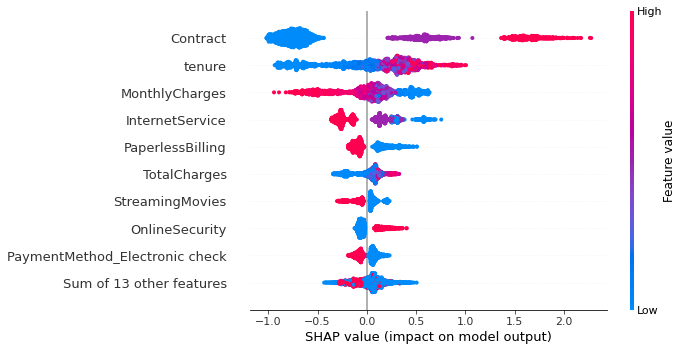

In [142]:
shap.plots.beeswarm(explanation)
plt.show()

In [143]:
# top 5 impact features are 1. contract 2. tenue 3. monthlycharges 4. internetservince 5. Payment method (electronic check)